<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Стационарность-ряда" data-toc-modified-id="Стационарность-ряда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Стационарность ряда</a></span></li><li><span><a href="#Диаграммы-автокорреляций-ACF-и-PACF,-генерация-признаков-(Скользящее-среднее-и-Отстающие-значения)" data-toc-modified-id="Диаграммы-автокорреляций-ACF-и-PACF,-генерация-признаков-(Скользящее-среднее-и-Отстающие-значения)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Диаграммы автокорреляций ACF и PACF, генерация признаков (Скользящее среднее и Отстающие значения)</a></span></li><li><span><a href="#Генерация-календарных-признаков" data-toc-modified-id="Генерация-календарных-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Генерация календарных признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Эконометрический-подход.-Метод-ARIMA-и-AutoReg" data-toc-modified-id="Эконометрический-подход.-Метод-ARIMA-и-AutoReg-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Эконометрический подход. Метод ARIMA и AutoReg</a></span></li><li><span><a href="#Регрессионные-модели-машинного-обучения" data-toc-modified-id="Регрессионные-модели-машинного-обучения-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Регрессионные модели машинного обучения</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Загрузка необходимых библиотек:

In [1]:
!pip install -q phik==0.11.1
!pip install -q scikit-learn==1.1.3
!pip install -q lightgbm
!pip install -q pmdarima

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
from lightgbm import LGBMRegressor
import phik
import pmdarima

In [3]:
# подготовка данных
from sklearn.model_selection import train_test_split
# модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
# метрика ошибки
from sklearn.metrics import mean_squared_error
# статистика
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import scipy as sp
from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

In [4]:
# криминала не было и я убрал warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Константы
RANDOM_STATE = 42
RMSE = 48
TEST_SIZE = 0.10

## Подготовка

Чтение исходных данных в таблицы(есть основание считать, что первая колонка может иметь тип времени, попробуем это учесть при чтении таблицы):

In [6]:
try:
    taxi2airport = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi2airport = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

На всякий случай удостоверимся, что данные монотонны по дате

In [7]:
if ~taxi2airport.index.is_monotonic_increasing: taxi2airport.sort_index(inplace=True)

###  Анализ данных 

Начальный размер таблицы:

In [8]:
full_size = taxi2airport.shape[0]
print('Количество оригинальных записей в таблице', full_size)

Количество оригинальных записей в таблице 26496


Выполним предобработку данных, предварительно оценив что должно содержаться в таблице

In [9]:
taxi2airport.sample(7).T

datetime,2018-03-14 17:00:00,2018-05-30 20:20:00,2018-05-22 16:20:00,2018-08-24 20:30:00,2018-08-24 19:10:00,2018-03-18 13:40:00,2018-05-06 12:40:00
num_orders,14,22,20,27,14,8,14


Выведем информацию о столбцах:

In [10]:
taxi2airport.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет 

In [11]:
print ('Начало периода наблюдений',taxi2airport.index[0])
print ('Окончание периода наблюдений',taxi2airport.index[-1])

Начало периода наблюдений 2018-03-01 00:00:00
Окончание периода наблюдений 2018-08-31 23:50:00


Данные представлены за 6 месяцев, начиная с марта 2018 года

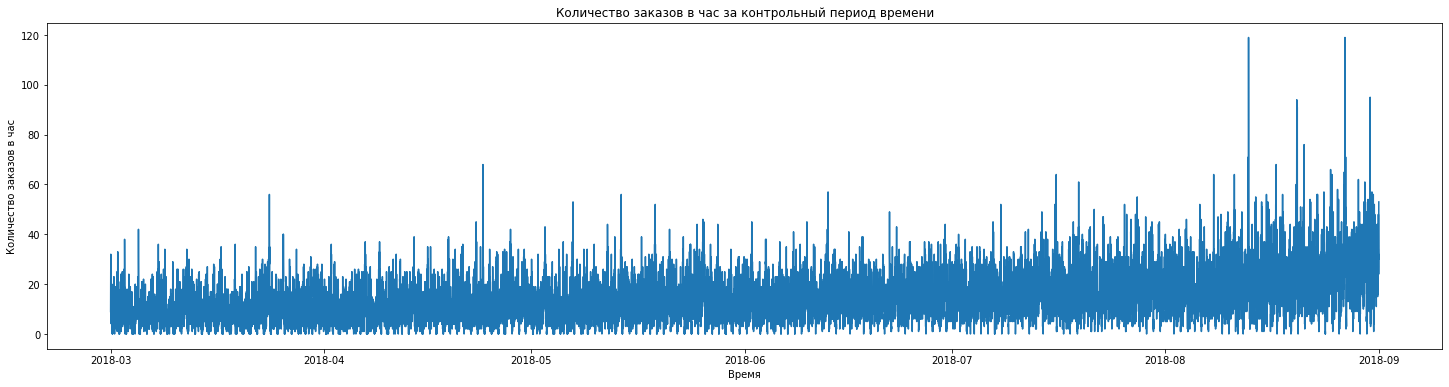

In [12]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(taxi2airport)
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов в час')
plt.title ('Количество заказов в час за контрольный период времени')
plt.show()

Посмотрим общие предельные значения:

In [13]:
taxi2airport.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


В среднем у час около 14 заказов, присутствуют часы простоя с 0 заказов.

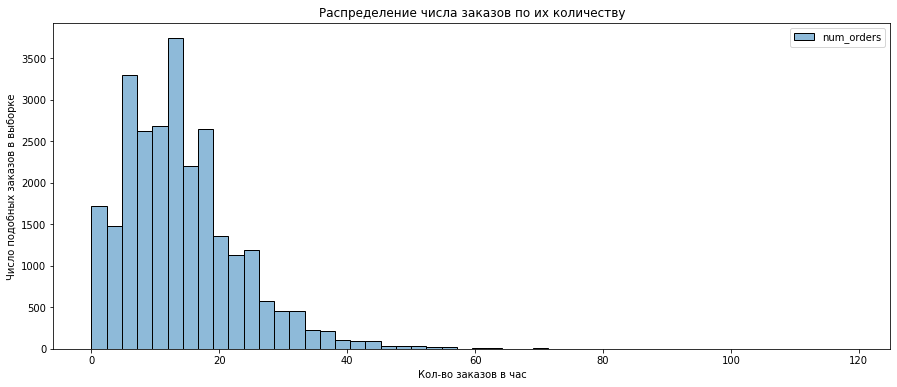

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=taxi2airport, bins=50, color='tab:orange')
ax.set_xlabel('Кол-во заказов в час')
ax.set_ylabel('Число подобных заказов в выборке')
plt.title ('Распределение числа заказов по их количеству')
plt.show()

###  Ресемплирование

Выполним  ресемплирование по одному часу

In [15]:
taxi2airport = taxi2airport.resample('1H').sum()

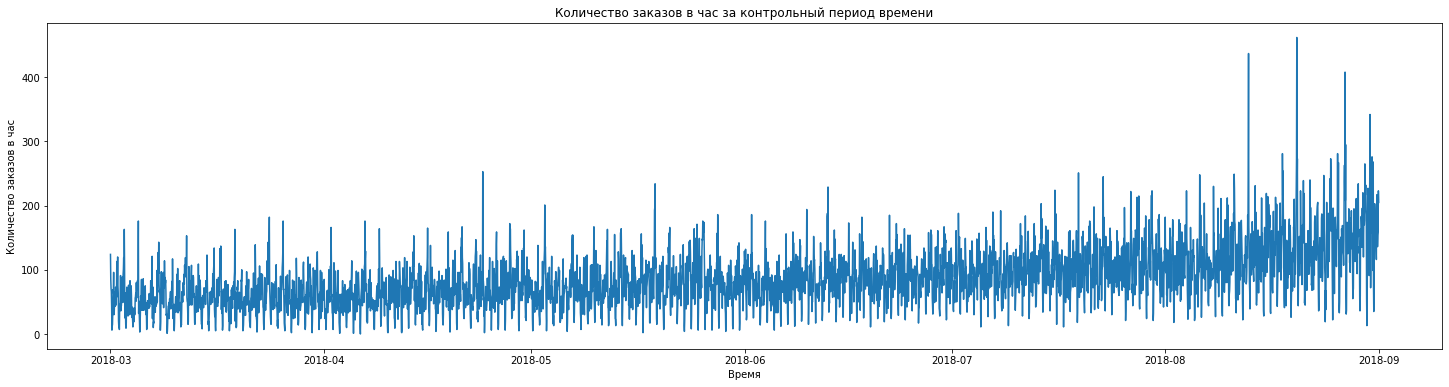

In [16]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(taxi2airport)
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов в час')
plt.title ('Количество заказов в час за контрольный период времени')
plt.show()

## Анализ

### Тренды и сезонность

Оценим наличие тренда и сезонности. Это пригодится при построении моделей и формировании набора признаков

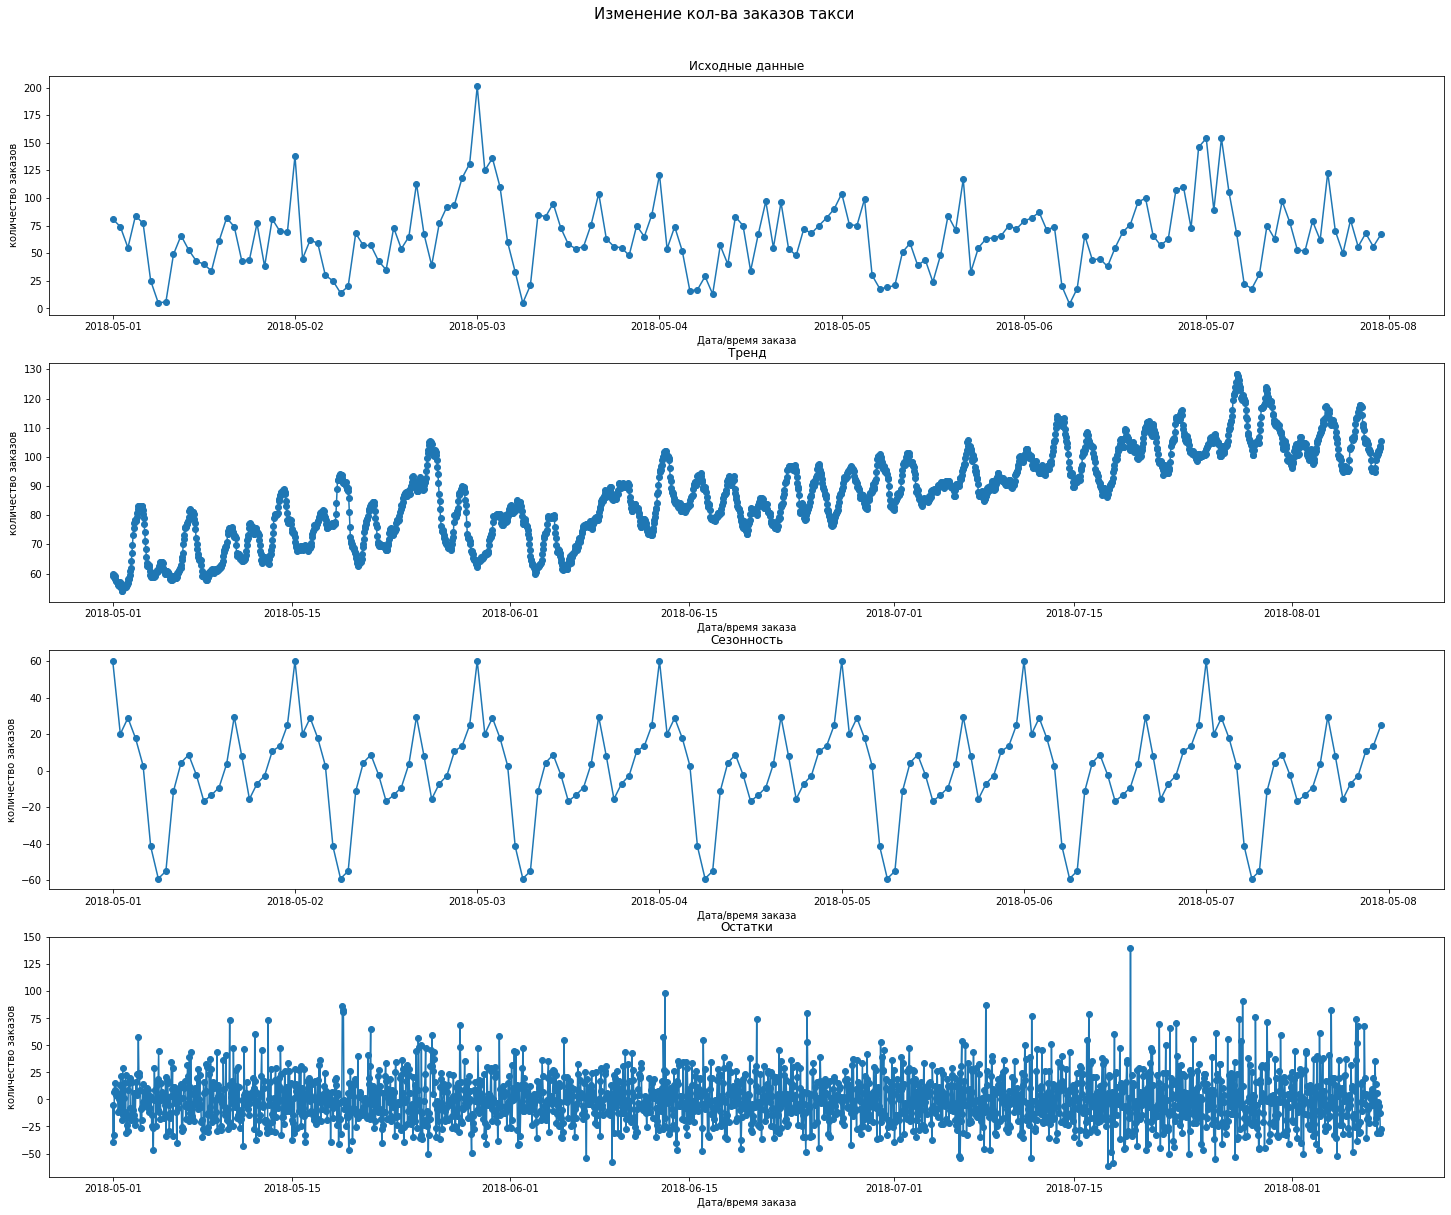

In [17]:
result = seasonal_decompose(taxi2airport, model='additive')
fig, ax = plt.subplots(4, figsize=(25, 19))
fig.suptitle('Изменение кол-ва заказов такси', fontsize=15)
fig.subplots_adjust(top = 0.93)
ax[0].plot(taxi2airport['2018-05-01':'2018-05-07'], marker='o')
ax[0].set_title('Исходные данные')
ax[1].plot(result.trend['2018-05-01':'2018-08-07'], marker='o')
ax[1].set_title('Тренд')
ax[2].plot(result.seasonal['2018-05-01':'2018-05-07'], marker='o')
ax[2].set_title('Сезонность')
ax[3].plot(result.resid['2018-05-01':'2018-08-07'], marker='o')
ax[3].set_title('Остатки')
for i, axis in enumerate(ax):
    ax[i].set_ylabel('количество заказов')
    ax[i].set_xlabel('Дата/время заказа')
plt.show()

Чтобы оценить насколько удалось использовать информацию содержащуюся в ряду, оценим распределение остатков на нормальность. Оценку нормальности распределения можно провести на основе теста Шапиро либо с использованием графического отображения в ввиде p-p диаграммах (график квантиль-квантиль). Тест Шапиро отображает вероятность случайного отклонения от нормального распределения, для случая p- value < 5% эта гипотеза отвергается. 

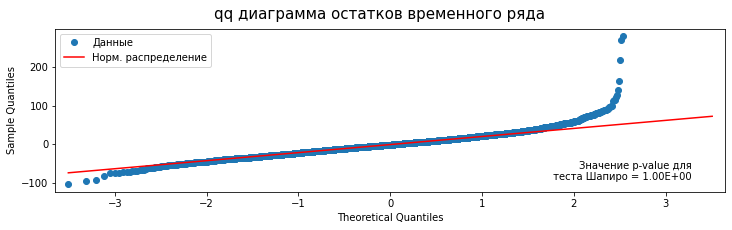

In [18]:
fig, ax = plt.subplots(figsize=(12, 3))
fig.suptitle('qq диаграмма остатков временного ряда', fontsize=15)
plt.subplots_adjust(wspace=0.5) 
tst=sp.stats.shapiro(result.resid)
sm.qqplot(result.resid, line='q', ax=ax)
ax.legend(['Данные', 'Норм. распределение'],
      loc="upper left",
      bbox_to_anchor=(0.0, 0, 0.1, 1))
ax.text(0.95, 0.07, f'Значение p-value для\n теста Шапиро = {tst.pvalue:.2E}' , transform=ax.transAxes, horizontalalignment='right')
plt.show()

Никакой дополнительной информации в остатках не осталось.

Можно отметить следующие наблюдения:
 - присутствует тренд к росту числа заказов;
 - сезонность заказов составляет 24 часа (1 день);
 - остатки распределены нормально, а следовательно не содержат дополнительной информации о ряде.


Кроме сезонности по дням, на диаграмме присутствуют небольшие пики, которые повторяются некоторой периодичностью. Попробуем оценить распределение заказов в течении дня.

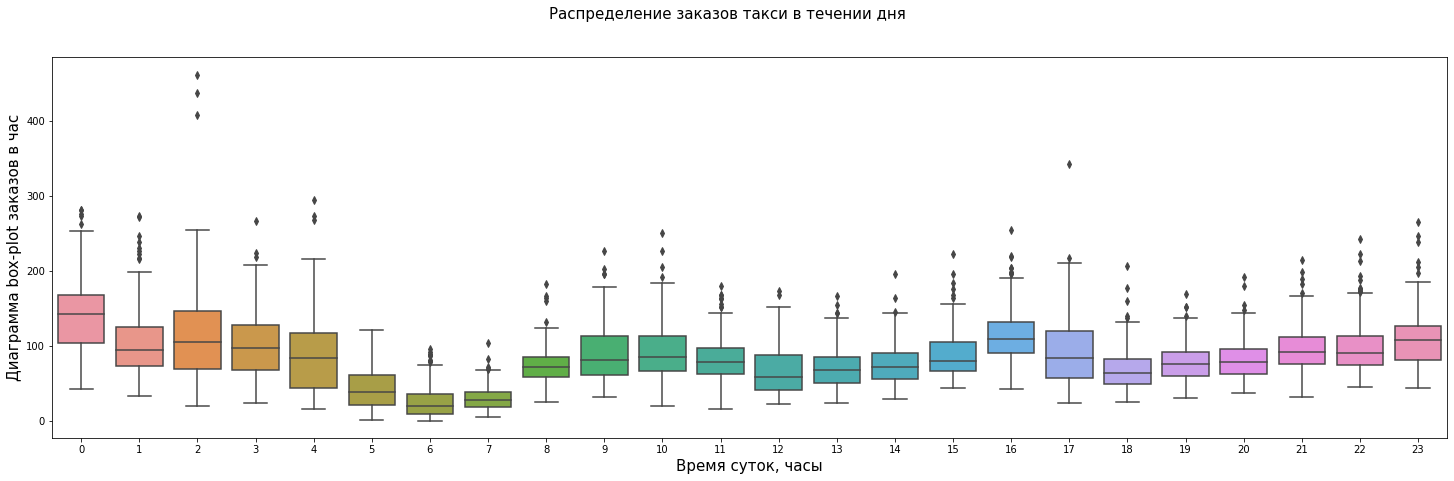

In [19]:
fig, ax = plt.subplots(1, figsize=(25,7))
fig.suptitle('Распределение заказов такси в течении дня', fontsize=15)
sns.boxplot(x=taxi2airport.index.hour, y='num_orders', data=taxi2airport)
plt.xlabel('Время суток, часы', fontsize=15);
plt.ylabel('Диаграмма box-plot заказов в час', fontsize=15);
plt.show()

 - Минимум заказов наблюдается в районе 6 часов утра;
 - Следующий максимум заказов в 10 утра;
 - Далее снижение до 12 часов и рост до 16;
 - С 16 до 18 часов опять снижение и далее рост до 12 ночи.
Таким образом пиковые нагрузки соответствуют периодам около 10 утра, 16 дня и ночью. Скорее всего ночью нет альтернатив для того, чтобы добраться до аэропорта. Привыкшие к определенному распорядку для люди стараются уехать у аэропорт после сборов с утра или после окончания рабочего дня.
Мне кажется по москве я бы не стал брать такси с часы пик, потому что проще уж аэроэкспрессами, а не стоять в пробках 2-3 часа(снижения с 6-9 утра, и после 17 часов с дальнейшем ростом за счет тех кто "с работы").

### Стационарность ряда

Перед тем, как перейти к моделированию, стоит оценить стационарность временного ряда

Используем тест Dickey-Fuller:
 - Нулевая гипотеза (H0): Означает, что временной ряд имеет единичный корень, то есть он нестационарен (p-value > 0.05);
 - Альтернативная гипотеза (H1): Временной ряд не имеет единичного корня, то есть он стационарен (p-value <= 0.05).

In [20]:
X = taxi2airport.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Так как ситуация является пограничной дополнительно исследуем наличие тренда в ряде с использование скользящего среднего за неделю.

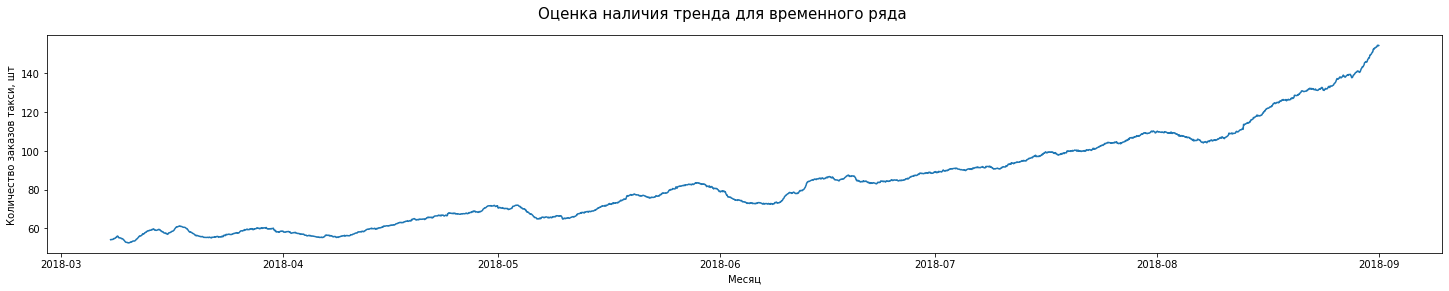

In [21]:
fig, ax = plt.subplots(1, figsize=(25, 4))
fig.suptitle('Оценка наличия тренда для временного ряда', fontsize=15)
plt.plot(taxi2airport['num_orders'].rolling(24*7).mean(), label='train')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов такси, шт');
plt.show()

Хотя тест Дики-Фуллера не дает однозначный ответ о стационарности временного ряда. График скользящего среднего показывает наличие тренда и говорит о **нестационарности ряда**. Свести нестационарным ряд к стационарному можно:

 - трансформацией типа Бокса-Кокса (для дисперсии);
 - дифференцирование для стабилизации трендов и сезонности.

Наличие тренда может помешать в его анализе, уберем его выполнив дифференцирование ряда с шагом в 1 час.

In [22]:
dSeriasdt = (taxi2airport-taxi2airport.shift(1)).dropna()
dSeriasdt = dSeriasdt.dropna() 
X = dSeriasdt.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.793234
p-value: 0.000000
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Далее для анализа можно избавиться от сезонности. Для этого возмем сезонную разность, от нашего получившегося ряда. Здесь следует отметить, что далее попробуем использовать несколько эконометрических моделей SARIMAX(с учетом сезонности) и AutoReg.

In [23]:
dSeriasdtdt = (dSeriasdt-dSeriasdt.shift(24)).dropna() 
X = dSeriasdtdt.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Dickey-Fuller')
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.208020
p-value: 0.000000
Нулевая гипотеза отвергается. Ряд стационарен по критерию Dickey-Fuller
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Стационарность ряда обеспечивается дифференцированием, для снижения дисперсии преобразуем ряд с помощью Бокса-Кокса трансформации

In [24]:
box2cox = taxi2airport.copy()
box2cox['num_orders'], lmbd = stats.boxcox(taxi2airport['num_orders']+1)

### Диаграммы автокорреляций ACF и PACF, генерация признаков (Скользящее среднее и Отстающие значения)

Для понимания сезонности и лага, построим графики ACF / PCF для исходного ряда, ряда разностей по одному часу и ряда разности второго порядка по периоду сезонности

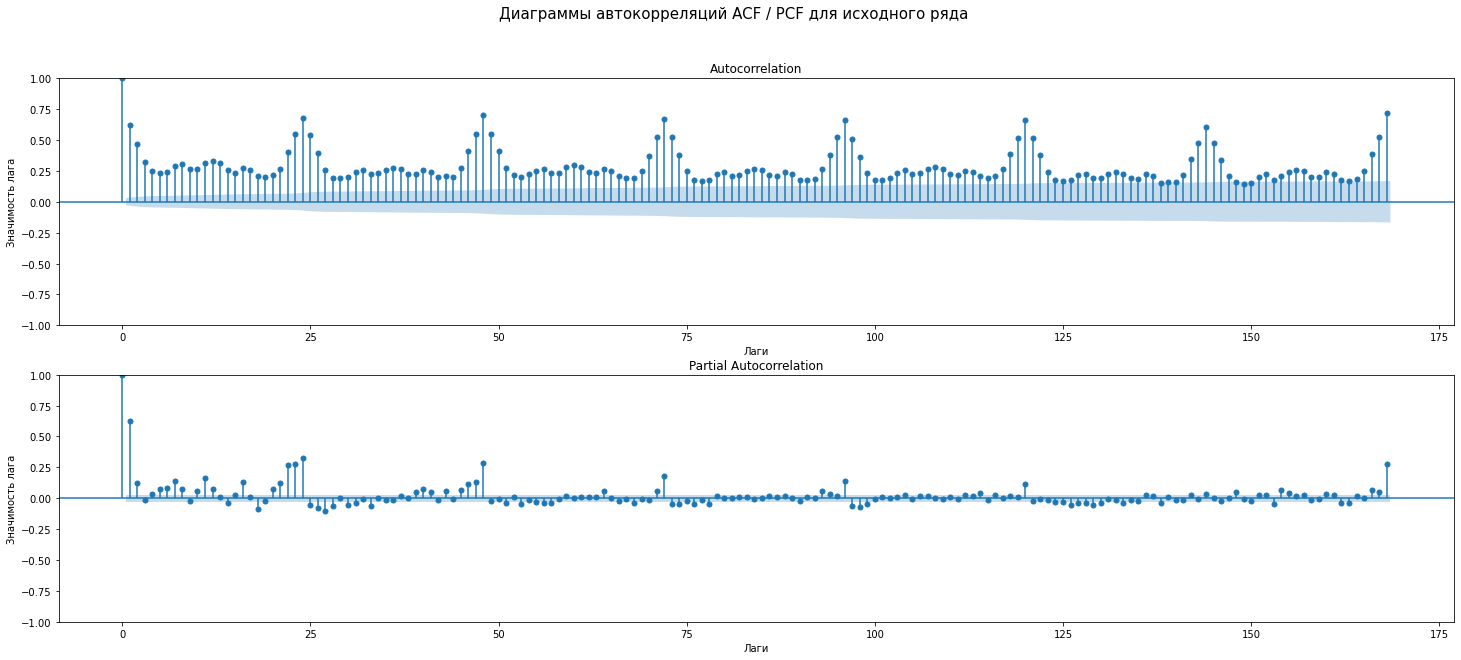

In [25]:
fig, ax = plt.subplots(2, figsize=(25, 10))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для исходного ряда', fontsize=15)
plot_acf(taxi2airport, ax= ax[0],  lags = 24*7)
plot_pacf(taxi2airport,  ax= ax[1], lags = 24*7, method='ywm')
for i, axis in enumerate(ax):
    ax[i].set_xlabel('Лаги')
    ax[i].set_ylabel('Значимость лага')
plt.show()

Все лаги на графике ACF положительны, что свидетельствуют о положительном тренде в данных. Это было отмечано и ранее.

Построим графики ACF / PCF для трансформированного ряда 

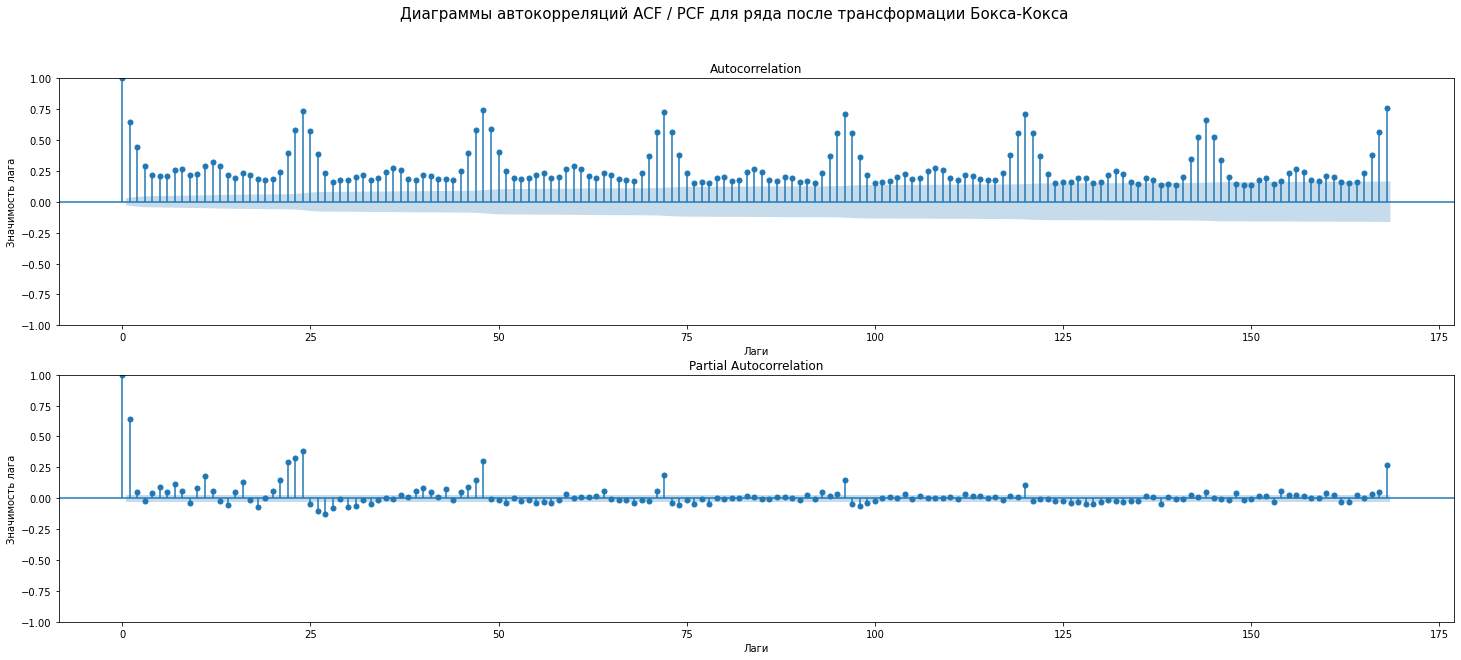

In [26]:
fig, ax = plt.subplots(2, figsize=(25, 10))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для ряда после трансформации Бокса-Кокса', fontsize=15)
plot_acf(box2cox, ax= ax[0],  lags = 24*7)
plot_pacf(box2cox,  ax= ax[1], lags = 24*7, method='ywm')
for i, axis in enumerate(ax):
    ax[i].set_xlabel('Лаги')
    ax[i].set_ylabel('Значимость лага')
plt.show()

Не чем особым не отличается, но будем использовать этот ряд для эконометрических моделей (априори считаем, что у него меньше дисперсия)

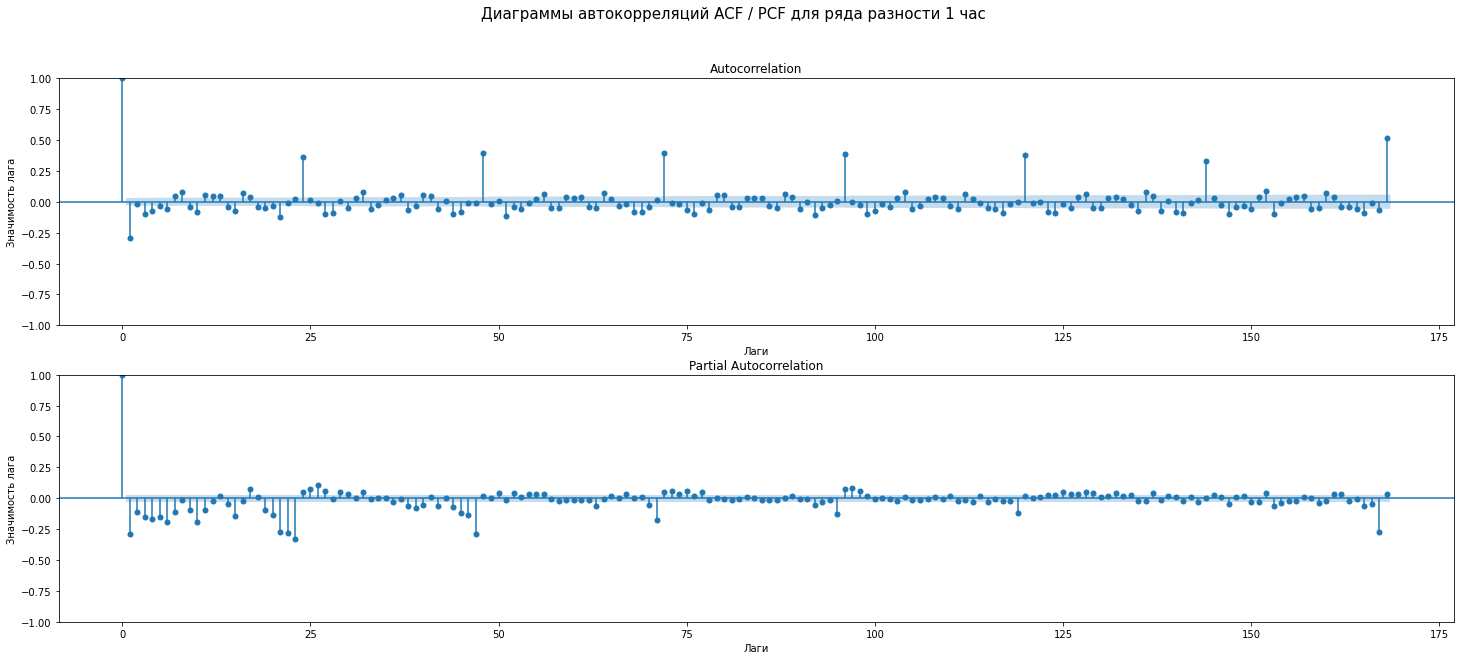

In [27]:
fig, ax = plt.subplots(2, figsize=(25, 10))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для ряда разности 1 час', fontsize=15)
plot_acf(dSeriasdt, ax= ax[0],  lags = 24*7)
plot_pacf(dSeriasdt,  ax= ax[1], lags = 24*7, method='ywm')
for i, axis in enumerate(ax):
    ax[i].set_xlabel('Лаги')
    ax[i].set_ylabel('Значимость лага')
plt.show()

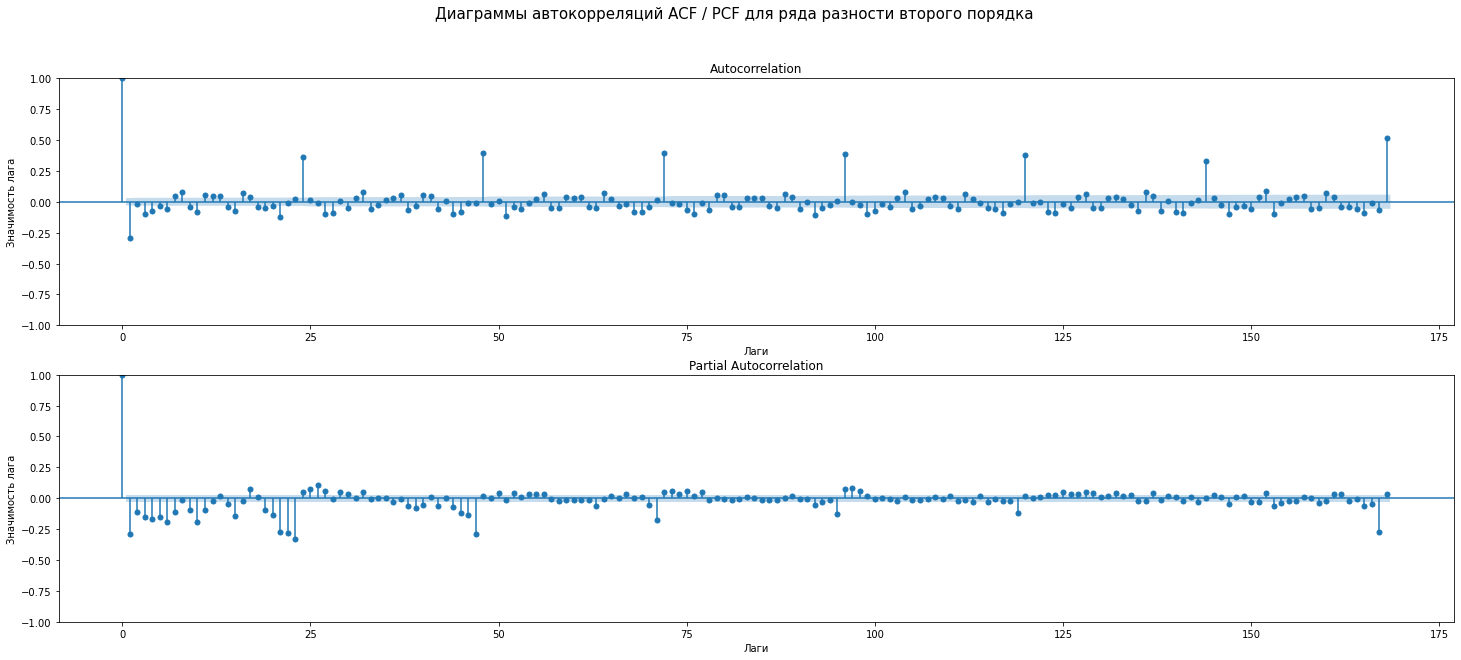

In [28]:
fig, ax = plt.subplots(2, figsize=(25, 10))
fig.suptitle('Диаграммы автокорреляций ACF / PCF для ряда разности второго порядка', fontsize=15)
plot_acf(dSeriasdt, ax= ax[0],  lags = 24*7)
plot_pacf(dSeriasdt,  ax= ax[1], lags = 24*7, method='ywm')
for i, axis in enumerate(ax):
    ax[i].set_xlabel('Лаги')
    ax[i].set_ylabel('Значимость лага')
plt.show()

Два последних ряда используем в эконометрическом подход (модели AutoReg, ARIMA и SARIMAX)

Диаграммы PCF позволяет оценить AR, тогда используем принятое обозначение и выделим следующие лаги:

In [29]:
ps = [1, 2, 3,  4,  8, 9,  12, 13, 21, 22, 23, 24*1, 24*2, 24*3 , 24*4, 24*5, 24*7, 27] 

Диаграммы ACF позволяет оценить MA, тогда используем принятое обозначение и выделим следующие скользящие средние (фактически сезонность):

In [30]:
qs = [24]  

Так как будет обучать и модели регрессии посмотрим матрицу корреляций phik для лагов и скользящего среднего:

In [31]:
lag_test = taxi2airport.copy()
lag_test['MA'] = taxi2airport['num_orders'].shift().rolling(24).mean()
for lag in ps:
    lag_test['AR_{}'.format(lag)] = lag_test['num_orders'].shift(lag)

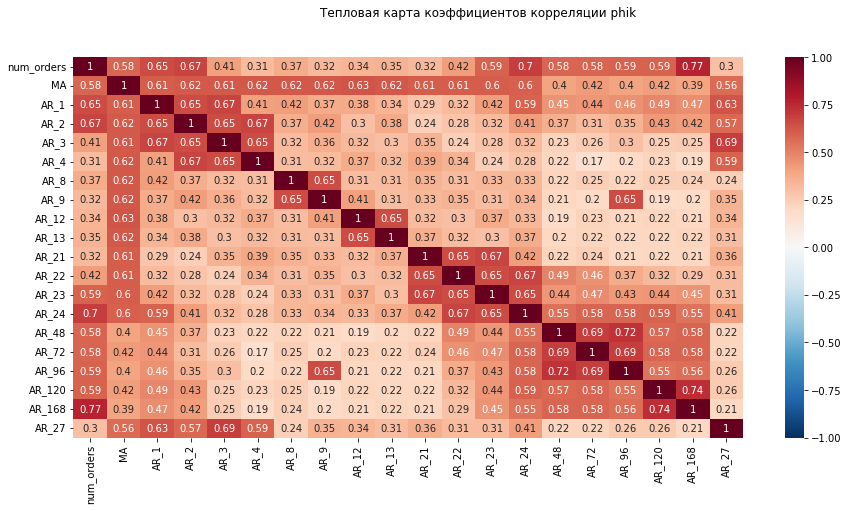

In [32]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = lag_test.phik_matrix(interval_cols= lag_test.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Видна устойчивая корреляционная связь с исходными значениями. Можно отметить, что если бы тут был бы ряд разностей она бы ослаблялась с ростом лага из-за отсутствия тренда.

In [33]:
feat_acf = lag_test.drop(columns = ['num_orders'])
feat_acf.sample(5)

,MA,AR_1,AR_2,AR_3,AR_4,AR_8,AR_9,AR_12,AR_13,AR_21,AR_22,AR_23,AR_24,AR_48,AR_72,AR_96,AR_120,AR_168,AR_27
datetime,,,,,,,,,,,,,,,,,,,
2018-03-16 09:00:00,60.041667,56.0,22.0,5.0,12.0,134.0,110.0,57.0,94.0,57.0,58.0,54.0,65.0,60.0,44.0,105.0,66.0,43.0,5.0
2018-08-23 10:00:00,127.833333,135.0,113.0,38.0,36.0,203.0,198.0,115.0,137.0,119.0,69.0,114.0,109.0,141.0,146.0,90.0,117.0,161.0,68.0
2018-08-26 03:00:00,139.750000,148.0,156.0,281.0,174.0,123.0,123.0,150.0,130.0,74.0,118.0,196.0,187.0,103.0,205.0,154.0,219.0,169.0,273.0
2018-06-30 23:00:00,91.958333,70.0,99.0,79.0,114.0,89.0,87.0,65.0,70.0,151.0,156.0,148.0,103.0,107.0,106.0,116.0,121.0,111.0,85.0
2018-08-12 23:00:00,111.500000,118.0,135.0,98.0,82.0,149.0,104.0,81.0,108.0,157.0,177.0,174.0,155.0,162.0,127.0,122.0,103.0,144.0,84.0


### Генерация календарных признаков

Под календарными признаками понимаем все данные, которые можно извлечь из дат временного ряда:

 - месяц;
 - неделя;
 - день недели;
 - день;
 - время суток(разделим на ночь, утро, день и вечер);
 - час.

In [34]:
feat_kalend = taxi2airport.copy()
feat_kalend['Day'] = taxi2airport.index.day
feat_kalend['Hour'] = taxi2airport.index.hour
feat_kalend['Week'] = taxi2airport.index.isocalendar().week
feat_kalend['DayofWeek'] = taxi2airport.index.dayofweek
feat_kalend['Month'] = taxi2airport.index.month
feat_kalend['TimeofDay'] = ((feat_kalend['Hour']+6)//6)
feat_kalend.head(5)

,num_orders,Day,Hour,Week,DayofWeek,Month,TimeofDay
datetime,,,,,,,
2018-03-01 00:00:00,124,1,0,9,3,3,1
2018-03-01 01:00:00,85,1,1,9,3,3,1
2018-03-01 02:00:00,71,1,2,9,3,3,1
2018-03-01 03:00:00,66,1,3,9,3,3,1
2018-03-01 04:00:00,43,1,4,9,3,3,1


Так как будет обучать и модели регрессии посмотрим матрицу корреляций phik для календарных признаков:

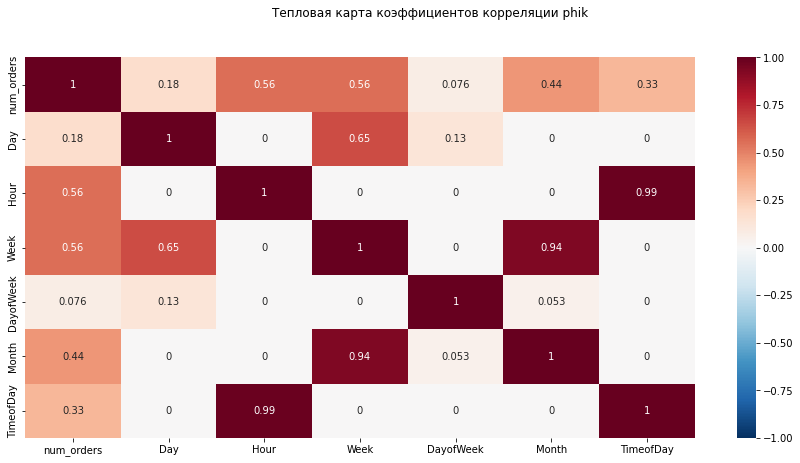

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = feat_kalend.phik_matrix(interval_cols= feat_kalend.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Присутствует мультиколлинеарность в признаках:

 - TimeofDay - Hour (уберем TimeofDay);
 - Week - Month (уберем Month, неделя года будет отвечать за тренд);
 - 
День недели похоже что не сильно коррелирует с числом заказов (что странно, все таки оставим его пока)

In [36]:
feat_kalend = feat_kalend.drop(columns = ['Month', 'TimeofDay'])
feat_kalend.sample(5)

,num_orders,Day,Hour,Week,DayofWeek
datetime,,,,,
2018-05-09 07:00:00,16,9,7,19,2
2018-04-25 01:00:00,37,25,1,17,2
2018-07-20 12:00:00,92,20,12,29,4
2018-07-19 13:00:00,57,19,13,29,3
2018-05-08 04:00:00,33,8,4,19,1


Новые временные признаки Day, Hour и DayofWeek цикличны, что может сбить с толку регрессионные модели. Закодируем их отдельно с использование sin/cos преобразования.

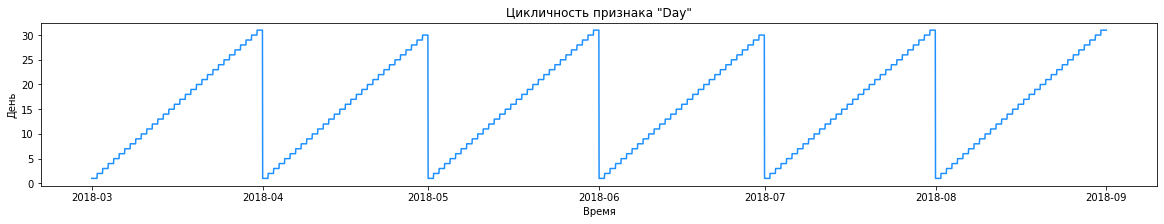

In [37]:
f, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(x=feat_kalend.index, y=feat_kalend['Day'], color='dodgerblue')
ax.set_title('Цикличность признака "Day"')
ax.set_xlabel('Время')
ax.set_ylabel('День')
plt.show()

In [38]:
days_in_month = 30
feat_kalend['Day_sin'] = np.sin(2*np.pi*feat_kalend['Day']/days_in_month)
feat_kalend['Day_cos'] = np.cos(2*np.pi*feat_kalend['Day']/days_in_month)
hours_in_day = 24
feat_kalend['Hour_sin'] = np.sin(2*np.pi*feat_kalend['Hour']/hours_in_day)
feat_kalend['Hour_cos'] = np.cos(2*np.pi*feat_kalend['Hour']/hours_in_day)
days_in_week = 24
feat_kalend['DayofWeek_sin'] = np.sin(2*np.pi*feat_kalend['DayofWeek']/days_in_week)
feat_kalend['DayofWeek_cos'] = np.cos(2*np.pi*feat_kalend['DayofWeek']/days_in_week)

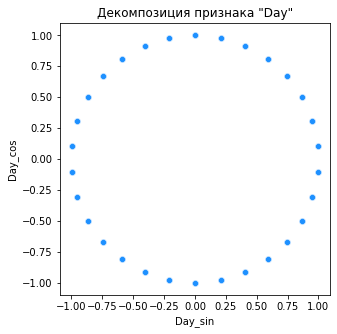

In [39]:
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=feat_kalend['Day_sin'], y=feat_kalend['Day_cos'], color='dodgerblue')
ax.set_title('Декомпозиция признака "Day"')
ax.set_aspect('equal', 'box')
plt.show()

In [40]:
feat_kalend = feat_kalend.drop(columns = ['Day', 'Hour', 'DayofWeek'])

Объединим признаки у одну таблицу:

In [41]:
frame2model = pd.concat([feat_kalend, feat_acf], axis=1)
frame2model.head(5)

,num_orders,Week,Day_sin,Day_cos,Hour_sin,Hour_cos,DayofWeek_sin,DayofWeek_cos,MA,AR_1,...,AR_21,AR_22,AR_23,AR_24,AR_48,AR_72,AR_96,AR_120,AR_168,AR_27
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,9,0.207912,0.978148,0.000000,1.000000,0.707107,0.707107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,9,0.207912,0.978148,0.258819,0.965926,0.707107,0.707107,NaN,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,9,0.207912,0.978148,0.500000,0.866025,0.707107,0.707107,NaN,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,9,0.207912,0.978148,0.707107,0.707107,0.707107,0.707107,NaN,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,9,0.207912,0.978148,0.866025,0.500000,0.707107,0.707107,NaN,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим на мультиколлинеарность

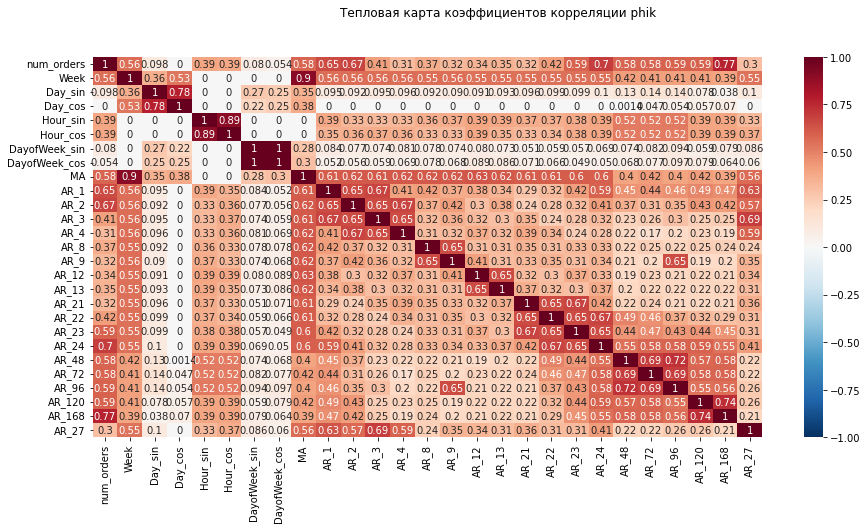

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))
cars = frame2model.phik_matrix(interval_cols= frame2model.columns);
sns.heatmap(
    cars,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

Неделя сильно коррелирует с MA, уберем неделю.

In [43]:
frame2model = frame2model.drop(columns = ['Week'])

Можно переходить к этапу моделирование.

## Обучение

### Эконометрический подход. Метод ARIMA и AutoReg

In [44]:
metrics = []

Разобьем исходный ряд и box2cox на тестовые и тренеровочные данные:

In [45]:
train, test = train_test_split(box2cox, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
train_len = len(train)
num_samples = len(box2cox)

In [46]:
train_ord, test_ord = train_test_split(taxi2airport, shuffle=False, test_size=TEST_SIZE)
train_ord = train_ord.dropna()

Для эконометрических моделей используем кросс-валидацию по пяти фолдам в "ручном режиме":

In [47]:
tcv = TimeSeriesSplit(n_splits=5)

Для кросс-валидации нужен специальный метод, так как "мешать" фолды нельзя, используем TimeSeriesSplit

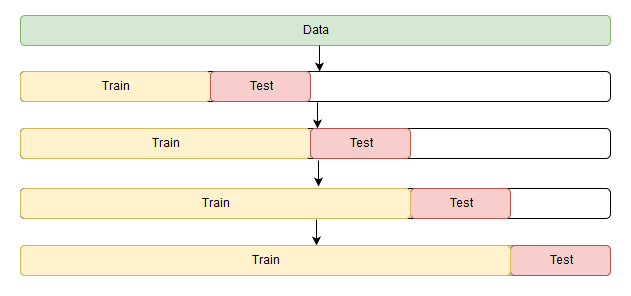

**Модель AutoReg**

Fold 0 done
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done


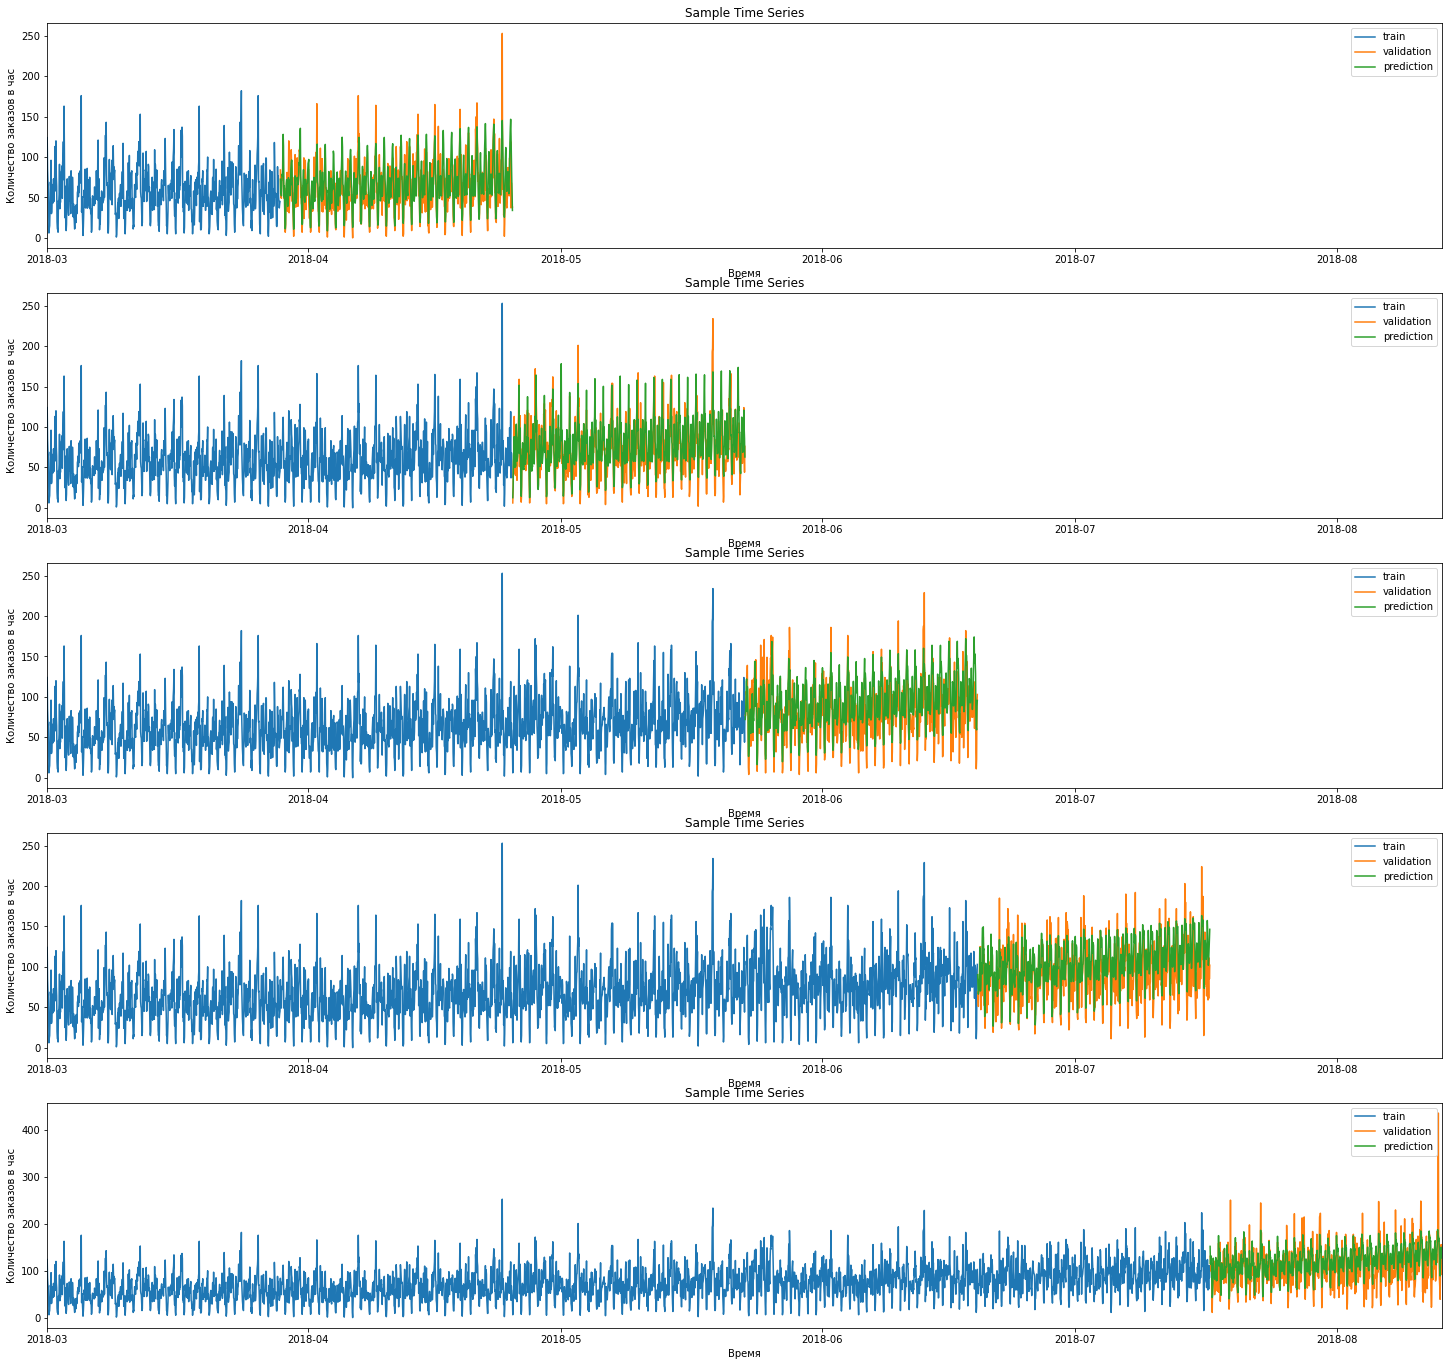

Точность модели AutoReg на кросс-валидации: RMSE =  26.593505600588145
CPU times: total: 1.7 s
Wall time: 1.68 s


In [48]:
%%time
cv_scores = np.empty(5)
f, ax = plt.subplots(5, figsize=(25, 24))
for idx, (train_idx, test_idx) in enumerate(tcv.split(train)):
    train_cv, test_cv = train.iloc[train_idx], train.iloc[test_idx]
    train_cv_ord, test_cv_ord = train_ord.iloc[train_idx], train_ord.iloc[test_idx]
    train_len = len(train)
    num_samples = len(taxi2airport)
    auto_reg_model = AutoReg(train_cv, lags=ps ).fit() 
    pred_cv = auto_reg_model.predict(start=len(train_cv), end=len(train_cv)+len(test_cv)-1, dynamic=False)
    inv_pred_cv = inv_boxcox(pred_cv, lmbd)-1
    inv_true_cv = inv_boxcox(test_cv['num_orders'], lmbd)-1
    cv_scores[idx] = mean_squared_error(inv_true_cv, inv_pred_cv, squared=False)
    print('Fold '+ str(idx) + ' done')
    ax[idx].plot(train_cv_ord, label='train')
    ax[idx].plot(test_cv_ord, label='validation')
    ax[idx].plot(inv_pred_cv, label='prediction')
    ax[idx].set_xlim(train.index[0], train.index[-1])
    ax[idx].set_title('Fold '+ str(idx))
    ax[idx].set_xlabel('Время')
    ax[idx].set_ylabel('Количество заказов в час')   
    ax[idx].legend(loc='upper right')
    ax[idx].set_title('Sample Time Series')
plt.show()
print('Точность модели AutoReg на кросс-валидации: RMSE = ', np.mean(cv_scores))
metrics.append(['AutoReg', np.mean(cv_scores)])

**Модель ARIMA**

Для модели ARIMA без учета сезонности подберем параметры на тренеровочных данных в пределах:

 - ps [1:12];
 - qs [1:24|]. 

In [49]:
auto_arima(train, test='adf', trace=True, error_action='ignore', suppress_warnings=True, max_p=12, max_q = 24, d=1, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22356.910, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22144.985, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22047.536, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22354.910, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22045.536, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22142.985, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.66 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 16.672 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Применим полученнуую модель для прогнозирования данных.

Fold 0 done
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done


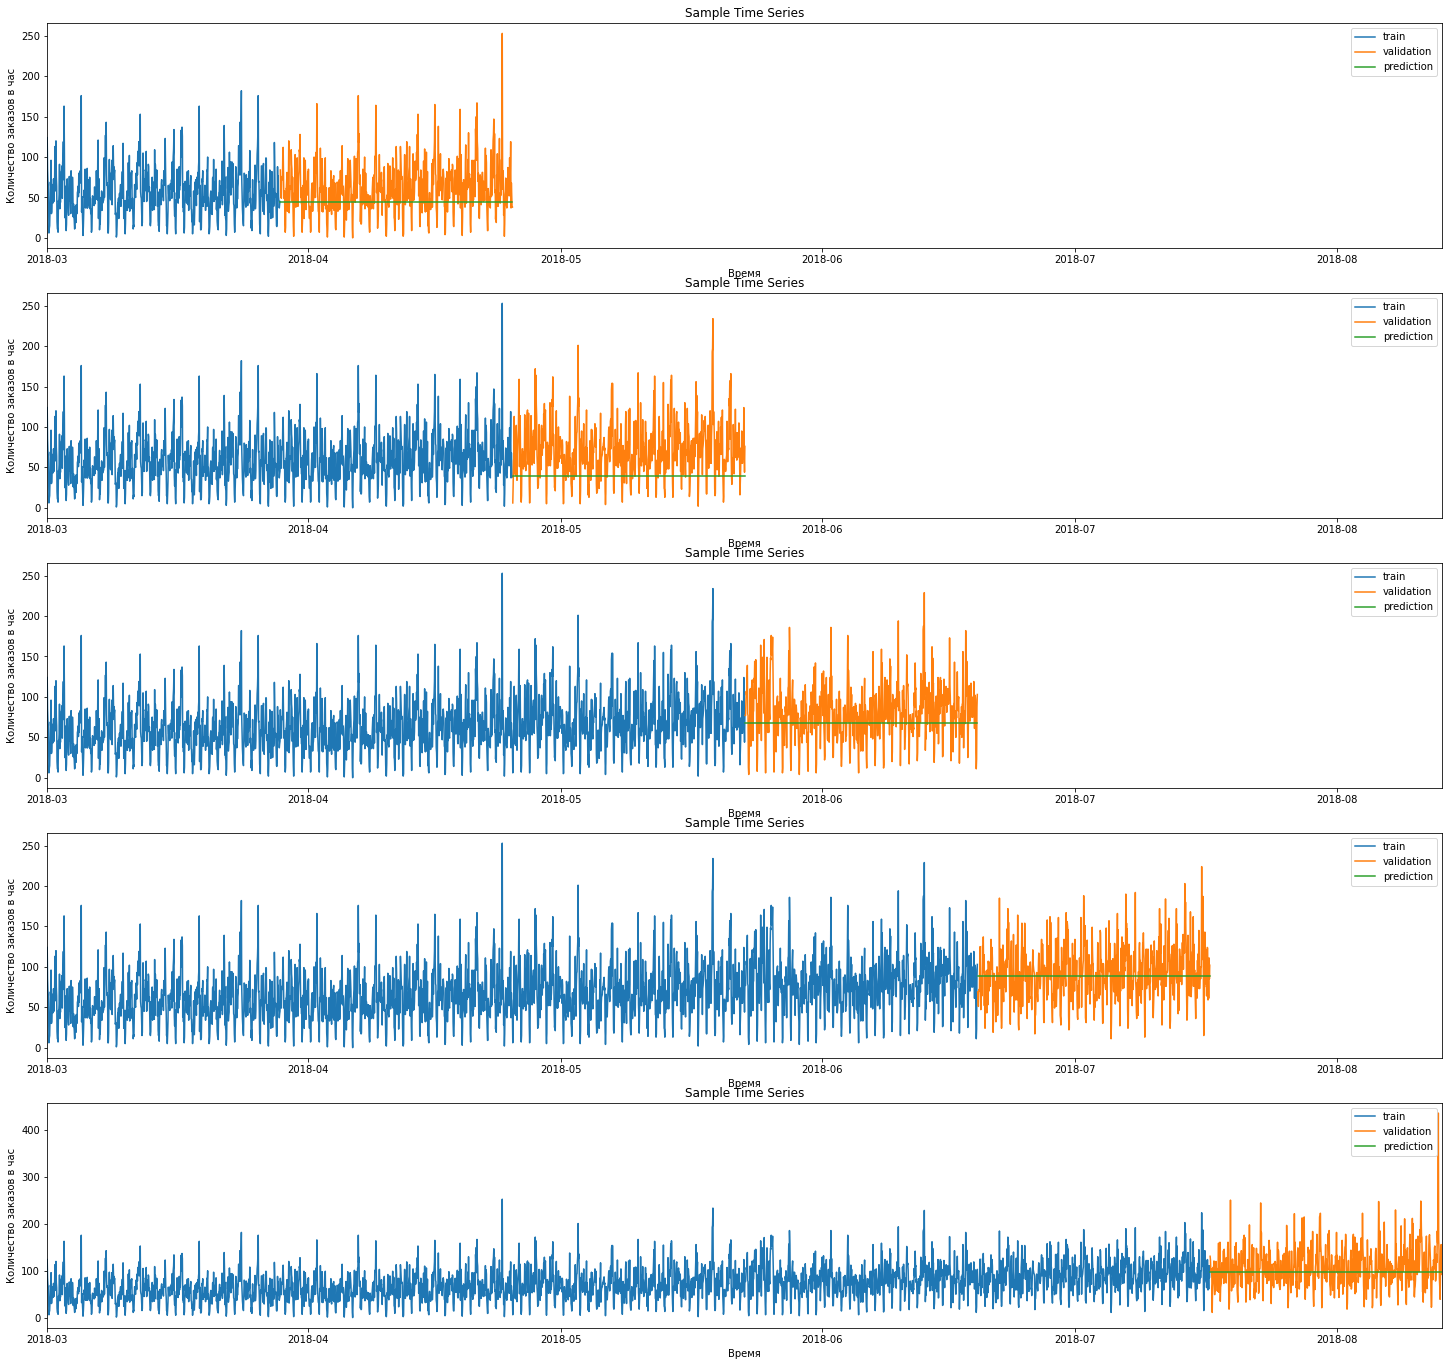

Точность модели ARIMA на кросс-валидации: RMSE =  39.257357907413315
CPU times: total: 1.89 s
Wall time: 1.87 s


In [50]:
%%time
cv_scores = np.empty(5)
f, ax = plt.subplots(5, figsize=(25, 24))
for idx, (train_idx, test_idx) in enumerate(tcv.split(train)):
    train_cv, test_cv = train.iloc[train_idx], train.iloc[test_idx]
    train_cv_ord, test_cv_ord = train_ord.iloc[train_idx], train_ord.iloc[test_idx]
    train_len = len(train)
    num_samples = len(taxi2airport)
    auto_reg_model = ARIMA(train_cv, order=(0,1,1)).fit()
    pred_cv = auto_reg_model.predict(start=len(train_cv), end=len(train_cv)+len(test_cv)-1, dynamic=False)
    inv_pred_cv = inv_boxcox(pred_cv, lmbd)-1
    inv_true_cv = inv_boxcox(test_cv['num_orders'], lmbd)-1
    cv_scores[idx] = mean_squared_error(inv_true_cv, inv_pred_cv, squared=False)
    print('Fold '+ str(idx) + ' done')
    ax[idx].plot(train_cv_ord, label='train')
    ax[idx].plot(test_cv_ord, label='validation')
    ax[idx].plot(inv_pred_cv, label='prediction')
    ax[idx].set_xlim(train.index[0], train.index[-1])
    ax[idx].set_title('Fold '+ str(idx))
    ax[idx].set_xlabel('Время')
    ax[idx].set_ylabel('Количество заказов в час') 
    ax[idx].legend(loc='upper right')
    ax[idx].set_title('Sample Time Series')
plt.show()
print('Точность модели ARIMA на кросс-валидации: RMSE = ', np.mean(cv_scores))
metrics.append(['ARIMA', np.mean(cv_scores)])

**Модель SARIMA**

В отличии от предыдущей модели может учитыват сезонность, которая у нас 24 часа. Подберем параметры в том же диапазоне. Для сокращения времени расчета отметим, что PS = 1, D=1 и QS=0 (я что то пробовал, но получается долго очень и прям не видно на горизонте улучшения качества). **Я загрузил на платформу, и у меня  ~третий~  четвертый раз "ядро умирает" так что закомментирую строчку.**

In [51]:
auto_arima(train, test='adf', trace=True, error_action='ignore', suppress_warnings=True, max_p=12,
           max_q=4, d=1, start_P=1, max_P=1, start_Q=0, max_Q=0, stepwise=True, maxiter = 15, seasonal=True, m=24)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=19884.236, Time=11.35 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=22356.910, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=20751.780, Time=3.67 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=22047.536, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=22354.910, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=19913.639, Time=9.05 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=19878.524, Time=11.13 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=21389.278, Time=1.54 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=19945.803, Time=7.13 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=20476.274, Time=6.11 sec
 ARIMA(3,1,1)(1,0,0)[24] intercept   : AIC=19862.600, Time=11.69 sec
 ARIMA(3,1,1)(0,0,0)[24] intercept   : AIC=21267.953, Time=1.71 sec
 ARIMA(3,1,0)(1,0,0)[24] intercept   : AIC=20336.615, Time=6.38 sec
 ARIMA(4

ARIMA(maxiter=15, order=(3, 1, 2), scoring_args={},
      seasonal_order=(1, 0, 0, 24), suppress_warnings=True)

Интересно что модель чувствительна к периоду и на долгосрочном прогнозе выдает константные значения его коротком значении. Можно в качестве периода указать 24*7 и тогда результат будет лучше, но время расчета значительно увеличится.

Fold 0 done
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done


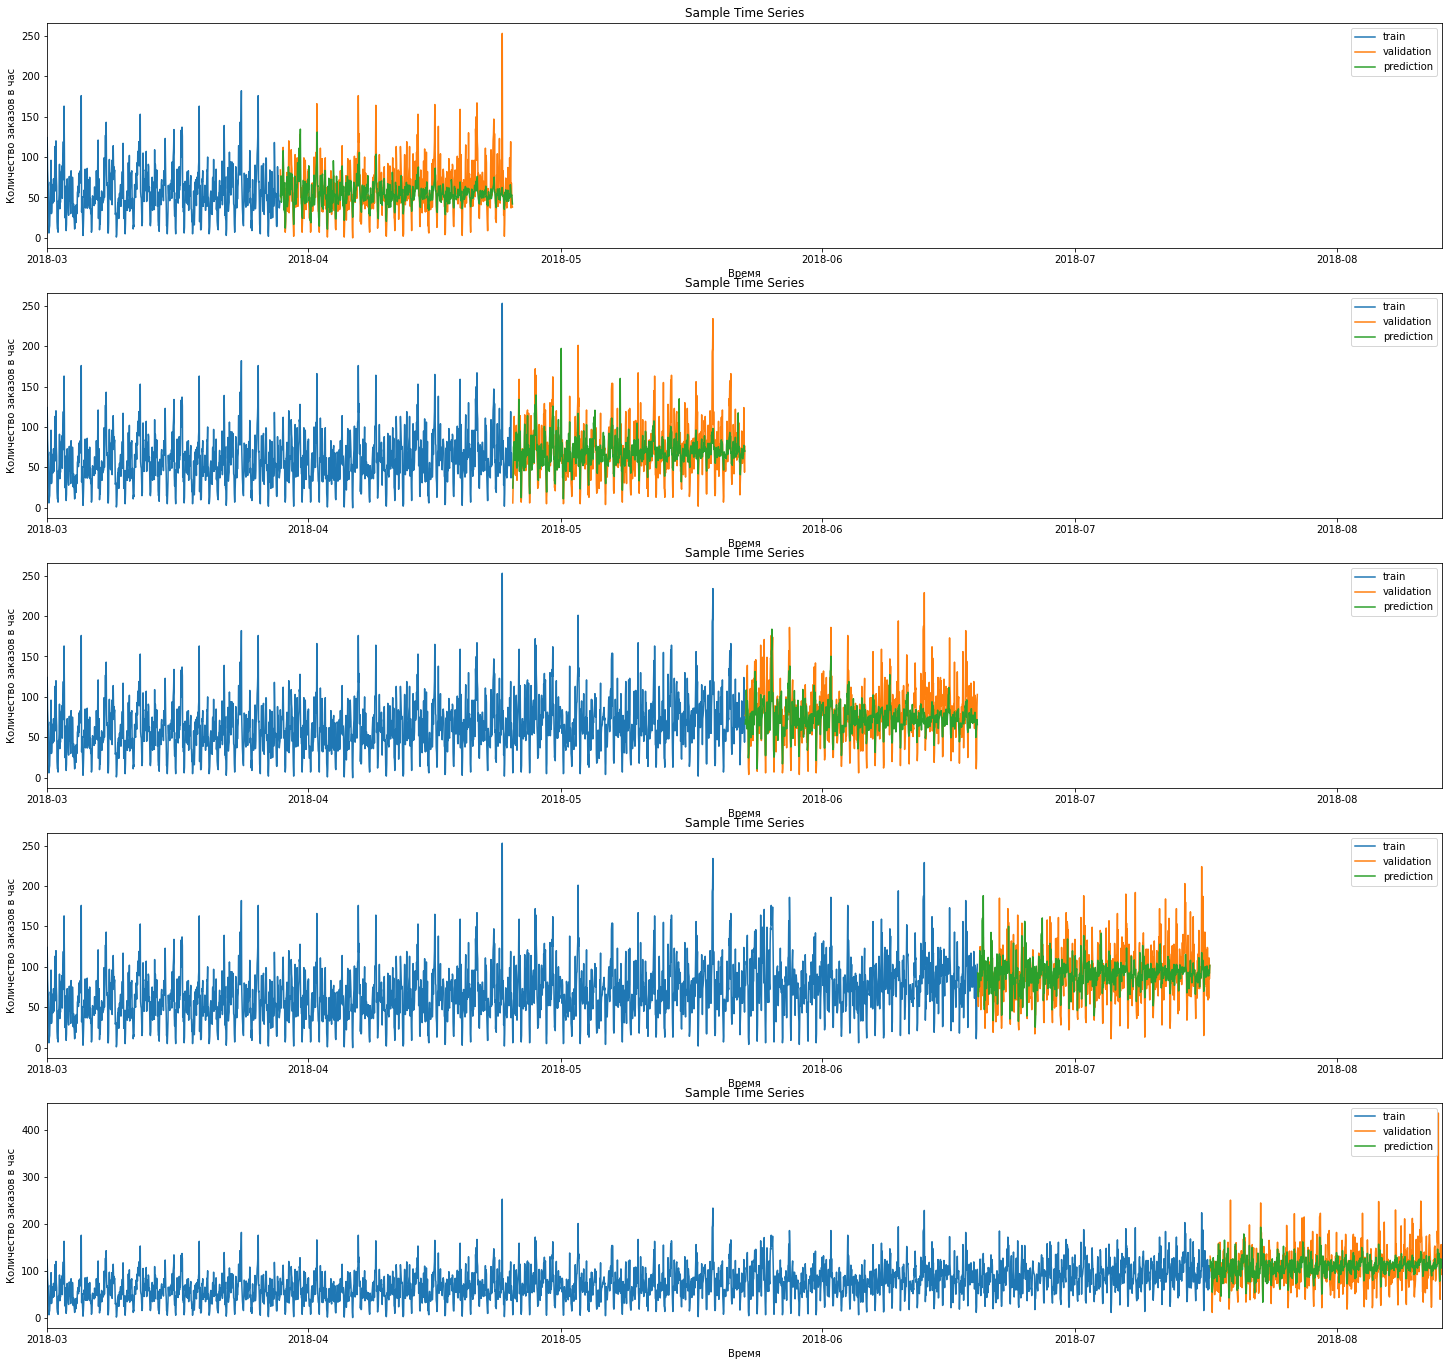

Точность модели SARIMAX на кросс-валидации: RMSE =  27.16076193832198
CPU times: total: 2h 2min 5s
Wall time: 53min 21s


In [52]:
%%time
cv_scores = np.empty(5)
f, ax = plt.subplots(5, figsize=(25, 24))
for idx, (train_idx, test_idx) in enumerate(tcv.split(train)):
    train_cv, test_cv = train.iloc[train_idx], train.iloc[test_idx]
    train_cv_ord, test_cv_ord = train_ord.iloc[train_idx], train_ord.iloc[test_idx]
    train_len = len(train)
    num_samples = len(taxi2airport)
    auto_reg_model = SARIMAX(train_cv, order=(3, 1, 2), seasonal_order=(1, 0, 0, 24*7)).fit()
    pred_cv = auto_reg_model.predict(start=len(train_cv), end=len(train_cv)+len(test_cv)-1, dynamic=False)
    inv_pred_cv = inv_boxcox(pred_cv, lmbd)-1
    inv_true_cv = inv_boxcox(test_cv['num_orders'], lmbd)-1
    cv_scores[idx] = mean_squared_error(inv_true_cv, inv_pred_cv, squared=False)
    print('Fold '+ str(idx) + ' done')
    ax[idx].plot(train_cv_ord, label='train')
    ax[idx].plot(test_cv_ord, label='validation')
    ax[idx].plot(inv_pred_cv, label='prediction')
    ax[idx].set_xlim(train.index[0], train.index[-1]) 
    ax[idx].set_title('Fold '+ str(idx))
    ax[idx].set_xlabel('Время')
    ax[idx].set_ylabel('Количество заказов в час') 
    ax[idx].legend(loc='upper right')
    ax[idx].set_title('Sample Time Series')
plt.show()
print('Точность модели SARIMAX на кросс-валидации: RMSE = ', np.mean(cv_scores))
metrics.append(['SARIMAX', np.mean(cv_scores)])

### Регрессионные модели машинного обучения

Разобьем сформированные данные на тестовые и тренеровочные

In [53]:
frame2model= frame2model.dropna()
train, test = train_test_split(frame2model, shuffle=False, test_size=TEST_SIZE)

Выделим в сформированной таблице, целевой признак и все остальные (которые числовые):

In [54]:
target = ['num_orders']
num_col = frame2model.select_dtypes(include=np.number).columns.values
num_col = num_col[~np.isin(num_col, target)]
argument_col = num_col

Создадим функцию для формирования PipeLine:

In [55]:
def prediction_model(X_num, NumScaler, model_step, types = None):
    # выбор масшабирования
    if NumScaler == 'Standart':
        Scaler = StandardScaler()
    elif NumScaler == 'Robust': 
        Scaler = RobustScaler()    
    elif NumScaler == 'Quantile': 
        Scaler = QuantileTransformer()
    else:
        Scaler = MinMaxScaler()
    num_features = X_num.tolist()
    # преобразование численных признаков
    num_steps = [('Scaler', Scaler)]
    # создаём пайплайы обработки
    num_transformer = Pipeline(num_steps)
    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_features)],        
        remainder='passthrough')
    # создаём итоговый пайплайн по шагам
    step_prep = ('preprocessor', data_preprocessor)
    # выбор модели 
    if model_step == 'Dummy':
        step_sol  = ('model', DummyRegressor(strategy="mean"))
    elif model_step == 'init':
        step_sol  = ('model', LinearRegression(n_jobs=-1))
    elif model_step == 'user':
        step_sol  = ('model', types)     
    # собираем шаги модели
    return Pipeline([step_prep, step_sol])

Проверим работоспоспособность на модели линейной регрессии:

In [56]:
lin_model = prediction_model(num_col, 'Min/Max', 'init')
lin_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Day_sin', 'Day_cos',
                                                   'Hour_sin', 'Hour_cos',
                                                   'DayofWeek_sin',
                                                   'DayofWeek_cos', 'MA',
                                                   'AR_1', 'AR_2', 'AR_3',
                                                   'AR_4', 'AR_8', 'AR_9',
                                                   'AR_12', 'AR_13', 'AR_21',
                                                   'AR_22', 'AR_23', 'AR_24',
                                                   'AR_48', 'AR_72', 'AR_96',
                                                   'AR_120', 'AR_168',
                                                   'AR_27'])])),
                ('model', LinearRegression(n_jobs=-1))])

In [57]:
tcv = TimeSeriesSplit(n_splits=5)

In [58]:
%%time
rmse_accure_cv = cross_val_score(
    lin_model,
    train[num_col],
    train[target],
    scoring='neg_mean_squared_error',
    cv=tcv,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: RMSE = ', np.sqrt(abs(rmse_accure_cv)))
metrics.append(['LinearRegression', np.sqrt(abs(rmse_accure_cv))])

Точность модели на тренировочной выборке: RMSE =  22.242182307065466
CPU times: total: 125 ms
Wall time: 28.1 s


Линейная модель показывает результат на тренировочных данных значительно лучше, чем необходимо, однако продолжим исследовать модели, чтобы получить лучшую

**Анализ моделей**

Исследуем следующие модели:
- Для **Ridge()** исследуем гиперпараметр alpha (l2 регуляризация);
- Для **Lasso()** исследуем гиперпараметр alpha (l1 регуляризация);
- Для **RandomForestRegressor()** max_depth ;
- Для **CatBoostRegressor()**  learning_rate;
- Для **LightGBM()**  learning_rate.

In [59]:
def param_grid_choose(type_of_model, min_samples_split, min_samples_leaf, alpha, learning_rate, n_estimators, max_depth):
# типы моделей DecisionTreeClassifier/KNeighborsClassifier/SVC/CatBoostClassifier/LogisticRegression
    if type_of_model == 'LightGBM':
        # словарь для модели LightGBM
        param_grid = [{
        'model': [LGBMRegressor(verbose=-1)],
        'model__num_leaves': num_leaves,
        'model__max_depth': max_depth,
        'model__max_bin': max_bin
                   }]    
    elif type_of_model == 'Ridge':
        # словарь для модели KNeighborsClassifier 
         param_grid = [{
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': alpha
  #        , 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
                      }]  
    elif type_of_model == 'Lasso':
        # словарь для модели Lasso
        param_grid = [{
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': alpha  
                    }]
    elif type_of_model == 'CatBoostRegressor':
        # словарь для модели CatBoostClassifier   
        param_grid = [{
        'model': [CatBoostRegressor(iterations=1000, random_state=RANDOM_STATE, loss_function='RMSE', logging_level ='Silent')],
        'model__learning_rate': learning_rate
                    }]
    elif type_of_model == 'RandomForestRegressor':
        # словарь для модели RandomForestRegressor   
        param_grid = [{
        'model': [RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)],
        'model__n_estimators': n_estimators, 
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf  
                    }]
    return param_grid

In [60]:
# Ridge&Lasso parameters
alpha               = [0.1, 0.5, 1, 5, 25, 50, 100]        
# CatBoostRegressor & LightGBM parameters
learning_rate       = [0.1, 0.25, 0.5, 0.75]
num_leaves          = [31, 33, 35, 37]
max_bin             = [200, 255, 300]
# RandomForestRegressor parameters
n_estimators        = [10, 100] # default 100     
max_depth           = [None, 3, 5, 7] # default None 
min_samples_split   = [2, 10, 20, 30, 35] 
min_samples_leaf    = [2, 10, 20, 30, 35] 

In [61]:
model_list = ['LightGBM' , 'Ridge', 'Lasso', 'CatBoostRegressor', 'RandomForestRegressor']
metrics_reg = []
for i, model in enumerate(model_list):
    time2start = time()
    params   = param_grid_choose(model, min_samples_split, min_samples_leaf, alpha, learning_rate, n_estimators, max_depth)
    searcher = RandomizedSearchCV(lin_model, 
                              param_distributions = params, 
                              cv=tcv,
                              scoring='neg_mean_squared_error',
                              random_state=RANDOM_STATE,
                              error_score='raise',
                              n_iter=10,
                              n_jobs=-1);
    searcher.fit(train[num_col], train[target].values.ravel())
    train_score = searcher.best_score_
    time2finish = time()
    dt = time2finish-time2start
    metrics_reg.append([model, np.sqrt(abs(train_score)), str(searcher.best_estimator_.get_params()["model"]), 
                    round(dt, 2), round(searcher.cv_results_['mean_fit_time'].mean(), 2), round(searcher.cv_results_['mean_score_time'].mean(), 2), 
                    searcher.best_estimator_["model"].get_params()])
    print (model+' done')
metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg.columns = ['model_list', 'RMSE-train', 'Лучшая модель', 'Время подбора гиперпараметров, сек', 'Время обучения модели, сек', 'Время предсказания модели, сек', 'Все параметры модели']
metrics_reg.index  = model_list
metrics_reg

LightGBM done
Ridge done
Lasso done
CatBoostRegressor done
RandomForestRegressor done


,model_list,RMSE-train,Лучшая модель,"Время подбора гиперпараметров, сек","Время обучения модели, сек","Время предсказания модели, сек",Все параметры модели
LightGBM,LightGBM,22.778445,"LGBMRegressor(max_bin=300, max_depth=3, num_le...",13.20,1.23,0.01,"{'boosting_type': 'gbdt', 'class_weight': None..."
Ridge,Ridge,22.223026,"Ridge(alpha=1, random_state=42)",0.27,0.01,0.01,"{'alpha': 1, 'copy_X': True, 'fit_intercept': ..."
Lasso,Lasso,22.278231,"Lasso(alpha=0.1, random_state=42)",0.22,0.01,0.01,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'..."
CatBoostRegressor,CatBoostRegressor,22.922265,<catboost.core.CatBoostRegressor object at 0x0...,65.83,18.61,0.02,"{'iterations': 1000, 'learning_rate': 0.1, 'lo..."
RandomForestRegressor,RandomForestRegressor,22.853833,"RandomForestRegressor(min_samples_leaf=10, min...",10.48,0.88,0.29,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."


In [62]:
metrics = pd.DataFrame(metrics)
metrics.columns = ['model_list', 'RMSE-train']
metrics_rez=pd.concat([metrics, metrics_reg[['model_list', 'RMSE-train']]], ignore_index=True).sort_values('RMSE-train')
metrics_rez

,model_list,RMSE-train
5,Ridge,22.223026
3,LinearRegression,22.242182
6,Lasso,22.278231
4,LightGBM,22.778445
8,RandomForestRegressor,22.853833
7,CatBoostRegressor,22.922265
0,AutoReg,26.593506
2,SARIMAX,27.160762
1,ARIMA,39.257358


Таким образом, лучшей моделью следует признать Ridge(~22.22). Используем ее для оценки результатов на тестовых данных. Можно отметить, что модель имеет второй порядок регуляризации и сама пренебрегает признакими с нулевой значимостью

Определим RMSE для лучшей модели на тестовой выборке

In [63]:
typic = Ridge(alpha=1, random_state=42)
final_model = prediction_model(num_col, 'Min/Max', 'user', typic)
final_model.fit(train[num_col], train[target].values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Day_sin', 'Day_cos',
                                                   'Hour_sin', 'Hour_cos',
                                                   'DayofWeek_sin',
                                                   'DayofWeek_cos', 'MA',
                                                   'AR_1', 'AR_2', 'AR_3',
                                                   'AR_4', 'AR_8', 'AR_9',
                                                   'AR_12', 'AR_13', 'AR_21',
                                                   'AR_22', 'AR_23', 'AR_24',
                                                   'AR_48', 'AR_72', 'AR_96',
                                                   'AR_120', 'AR_168',
                                                   'AR_27'])])),
                ('model', Ridge(alpha=1, random_state=42))])

In [64]:
y_pred = final_model.predict(test[num_col])
print('Точность модели на тестовой выборке: RMSE = ',mean_squared_error(test[target].values.ravel(), y_pred, squared=False))

Точность модели на тестовой выборке: RMSE =  34.179751637461486


Чтобы показать, что модель работает сравним ее с результатами константной модель Dummy

In [65]:
Dummy_model = prediction_model(num_col, 'Min/Max', 'Dummy')
Dummy_model.fit(train[num_col], train[target].values.ravel())
y_dummy = Dummy_model.predict(test[num_col])
print('Точность модели на тестовой выборке: RMSE = ',mean_squared_error(test[target].values.ravel(), y_dummy, squared=False))

Точность модели на тестовой выборке: RMSE =  84.45113423436631


Качество модели продемонстировано, покажем результат графически

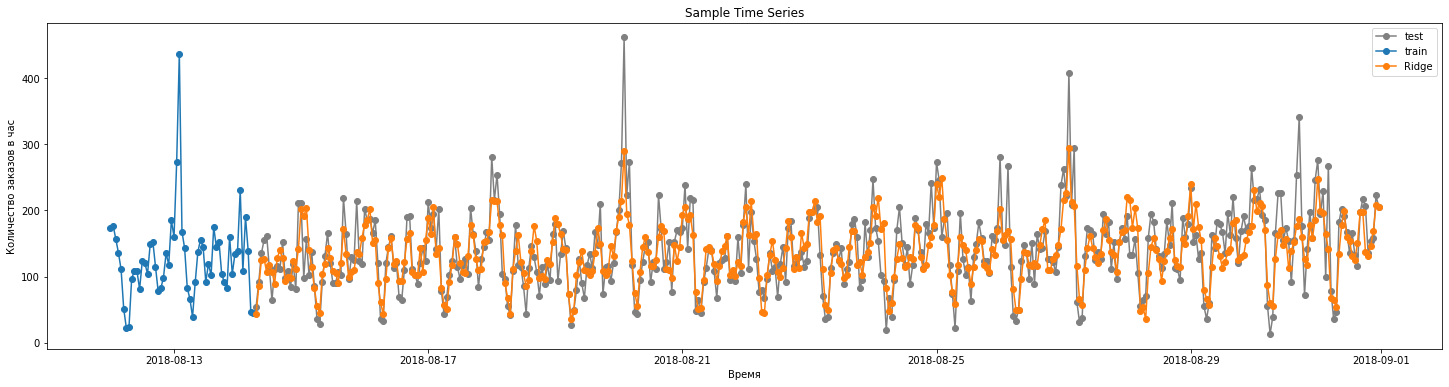

In [66]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
plt.plot(frame2model[test.index[0]:test.index.max()]['num_orders'], marker='o', label='test', color='grey')
plt.plot(frame2model['2018-08-12':train.index.max()]['num_orders'], marker='o', label='train')
plt.plot(test.index, y_pred, marker='o', label='Ridge')
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов в час') 
ax.legend(loc='upper right')
ax.set_title('Sample Time Series')
plt.show()

## Выводы

* Данные загружены, пропусков и дубликатов не имеется. Произведена сортировка по времени. Произведено ресемплирование данных по часу. Сгенерированы календарные признаки, скользящее среднее и отстающие значения. Полученные данные разделены на обучающую и тестовую выборки. Данные разделены на признаки и целевой признак;
* Произведен анализ трендов и сезонности в данных;
* Подобраны гиперпараметры для моделей;
* Модели обучены и с помощью них сделаны предсказания. RMSE для всех моделей;
* Лучшей моделью из эконометрических является AutoReg, модели класса ARIMA из-за сложности в обучении большого количества признаков склонны игнорировать длительные данные и использовать средние значения. Дифференцирование и преобразование Бокс-Кокса не помогли достичь характеристик регрессионных моделей;
* Для регрессионных моделей лучшие результаты показала модель Ridge - значения по кросс-валидации 22.22, а  для тестовых данных 34;
* Интересно отметить, что регрессионные модели показали лучшие результаты чем эконометрические.